<a href="https://colab.research.google.com/github/robd123/AML/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib.request
import os
datapath = os.path.join("datasets", "epi", "")
os.makedirs(datapath, exist_ok=True)
file_path = "https://raw.githubusercontent.com/robd123/AML/main/Project2/epi_r.csv"
urllib.request.urlretrieve(file_path, datapath + "epi_r.csv")

('datasets/epi/epi_r.csv', <http.client.HTTPMessage at 0x7f29a8d3b990>)

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

food = pd.read_csv(datapath + "epi_r.csv", thousands=',')
food.sort_values(by=['calories'], ascending=False).head()


,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,almond,amaretto,anchovy,anise,anniversary,anthony bourdain,aperitif,appetizer,apple,apple juice,apricot,arizona,artichoke,arugula,asian pear,asparagus,aspen,atlanta,australia,avocado,back to school,backyard bbq,bacon,bake,banana,...,vegan,vegetable,vegetarian,venison,vermont,vermouth,vinegar,virginia,vodka,waffle,walnut,wasabi,washington,"washington, d.c.",watercress,watermelon,wedding,weelicious,west virginia,westwood,wheat/gluten-free,whiskey,white wine,whole wheat,wild rice,windsor,wine,winter,wisconsin,wok,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
11391,Pear-Cranberry Mincemeat Lattice Pie,4.375,30111218.0,200968.0,1722763.0,27675110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6368,Deep-Dish Wild Blueberry Pie,4.375,29997918.0,200210.0,1716279.0,27570999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19672,"Apricot, Cranberry and Walnut Pie",4.375,13062948.0,87188.0,747374.0,12005810.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2976,Lamb Köfte with Tarator Sauce,5.000,4518216.0,166471.0,44198.0,7540990.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9731,"Rice Pilaf with Lamb, Carrots, and Raisins",5.000,4157357.0,236489.0,221495.0,3134853.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Data Preprocessing**


*   Replace missing values with median values.
*   Use standard scaler.
*   Remove food with less than 50 calories, most of these are recipes for preparing ingredients like stock or clarified butter.  Since we're trying to rate meals they can be safely removed.
*   Remove food with over 5000 calories.  Since the goal is to rate meals, there needs to be some way to correct for serving size.  There are 2 options I can think of: remove meals with more calories than can be considered a 'meal', or evaluate the meal in terms of sodium per calorie, etc.  I chose the first one.
*  Epicurious does not allow a zero rating, so any recipe that has a zero has not been rated.  This can be considered missing data, since its the value I'm trying to predict it doesn't make to give use the imputer to fill it in.

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

food_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

food = food.drop(columns = ['title'])
food = food[food.calories > 50]  # Remove ingredients
food = food[food.calories < 5000]  # Remove foods that have way more calories than can be considered a meal
food = food[food.sodium < 5000]  # Remove meals that have a hazardous amount of sodium
food = food[food.rating > 0]  # Remove unrated recipes

food = food.drop_duplicates(keep='first')  # Remove duplicate recipes

food_scaled = food_pipeline.fit_transform(food_data)

#print(food.columns)

food_new = food.drop(columns = ['rating', 'calories', 'sodium', 'fat', 'protein'])

food_scaled_all = np.concatenate((food_scaled, food_new), axis = 1)

food_scaled_all = pd.DataFrame(food_scaled_all, columns=food.columns)
food_scaled = pd.DataFrame(food_scaled, columns=['rating', 'calories', 'protein', 'fat', 'sodium'])

print(food_scaled.head())




     rating  calories   protein       fat    sodium
0 -2.452470 -0.151709  0.286741 -0.628321  0.020446
1  0.438484 -0.201906 -0.111954 -0.160839  1.365953
2 -0.525167 -0.721339 -0.510650 -0.628321 -0.581974
3 -1.488818  0.112373 -0.045505  0.102120 -0.143155
4  0.438484  0.987551 -0.078730  1.475348  0.758946


In [ ]:
food.sort_values(by=['rating'], ascending=True).head()

In [ ]:
food_scaled.corr()['rating'].sort_values(ascending=False)

In [ ]:
food_scaled.hist(bins=50, figsize=(20,15))

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ['rating', 'calories', 'protein', 'fat', 'sodium']
scatter_matrix(food_scaled[attributes], figsize=(20,15))


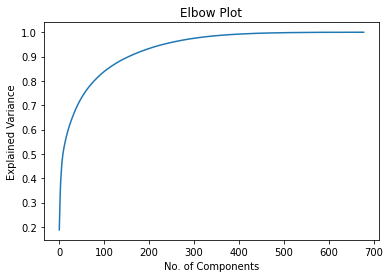

In [62]:
from sklearn.decomposition import PCA

food_pca = PCA()
food_pca.fit(food_scaled_all)
tr_food_pca = food_pca.transform(food_scaled_all)

plt.plot(np.cumsum(food_pca.explained_variance_ratio_))
plt.xlabel('No. of Components')
plt.ylabel('Explained Variance')
plt.title('Elbow Plot')
plt.show()

In [54]:
cumsum = np.cumsum(food_pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

232


In [63]:
#Extract variable that I want to predict
cake_week = food_scaled_all['#cakeweek']
wasteless = food_scaled_all['#wasteless']
twenty_two_minute = food_scaled_all['22-minute meals']
three_ingredient = food_scaled_all['3-ingredient recipes']
bourdain = food_scaled_all['anthony bourdain']
appetizer = food_scaled_all['appetizer']
alcoholic = food_scaled_all['alcoholic']

food_scaled_all.drop(columns = ['#cakeweek', '#wasteless', '22-minute meals', '3-ingredient recipes', 'anthony bourdain', 'appetizer', 'alcoholic'])

,rating,calories,protein,fat,sodium,30 days of groceries,advance prep required,alabama,alaska,almond,amaretto,anchovy,anise,anniversary,aperitif,apple,apple juice,apricot,arizona,artichoke,arugula,asian pear,asparagus,aspen,atlanta,australia,avocado,back to school,backyard bbq,bacon,bake,banana,barley,basil,bass,bastille day,bean,beef,beef rib,beef shank,...,vegan,vegetable,vegetarian,venison,vermont,vermouth,vinegar,virginia,vodka,waffle,walnut,wasabi,washington,"washington, d.c.",watercress,watermelon,wedding,weelicious,west virginia,westwood,wheat/gluten-free,whiskey,white wine,whole wheat,wild rice,windsor,wine,winter,wisconsin,wok,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,-2.452470,-0.151709,0.286741,-0.628321,0.020446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.438484,-0.201906,-0.111954,-0.160839,1.365953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.525167,-0.721339,-0.510650,-0.628321,-0.581974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.488818,0.112373,-0.045505,0.102120,-0.143155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.438484,0.987551,-0.078730,1.475348,0.758946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12735,-0.525167,1.096676,1.117357,1.504566,2.264997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12736,0.438484,0.383001,0.020944,-0.014751,0.057142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12737,0.438484,0.147292,0.319966,0.277425,0.162642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12738,0.438484,0.295702,0.785111,-0.131622,-0.043771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0